https://unimibfisicalaboratori.github.io/UnimibFisicaLabStatPythonWebBook/lectures/Lecture_11/EXERCISES.html

In [19]:
import numpy as np
import matplotlib.pyplot as plt
from iminuit import Minuit
from iminuit.cost import LeastSquares
from scipy.stats import chi2



from IPython.display import Latex

<h1> Data

In [20]:
def func1(x,a,b):
    return a*x**2+b*x

In [21]:
def linear(x,a):
    return a*x

In [22]:
def genData(xMin,xMax,theta:list,sigma,N:int,func=func1):

    x = np.linspace(xMin,xMax,N)
    y = np.empty(N)

    for i in range(N):
        
        y[i] = func(x[i],theta[0],theta[1]) + np.random.normal(0,sigma)

    return x,y

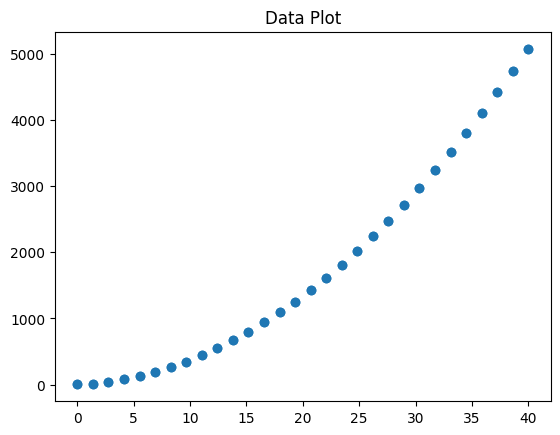

In [23]:
xmin,xmax = 0 , 40
N     = 30
sigma = 1

a,b = 3,7

data = genData(xmin,xmax,(a,b),sigma,N)


sigmay = [sigma for i in range(N)]

plt.title("Data Plot")
plt.scatter(data[0],data[1])
plt.errorbar(data[0],data[1], xerr=0,yerr=sigmay, linestyle = 'None', marker='o')
plt.show()

<h3>Fitting the data

In [24]:
dataFit = LeastSquares(data[0],data[1],sigmay,func1)

my_minuit = Minuit(dataFit,a=0,b=0)
my_minuit.migrad()
my_minuit.hesse()

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 35.54 (χ²/ndof = 1.3)      │              Nfcn = 55               │
│ EDM = 5.54e-16 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ a    │  3.0002   │  0.0010   │            │            │         │         │       │
│ 1 │ b    │   6.991   │   0.031   │            │            │         │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───┬───────────────────┐
│   │        a        b │
├───┼───────────────────┤
│ a │ 9.92e-07 -30.3e-6 │
│ b │ -30.3e-6 0.000984 │
└───┴───────────────────┘

In [25]:
a_est = my_minuit.values[0]
b_est = my_minuit.values[1]

Latex(f"$$a = {a} \\newline b = {b} \\newline a = {my_minuit.values[0]} \pm {a_est} \\newline b = {my_minuit.values[1]} \pm {b_est}$$")

<IPython.core.display.Latex object>

<h3>Quality of the fit

In [26]:
def Q_sqr(sample,sigma,func,a,b):
    
    sum = 0

    for x,y in zip(sample[0],sample[1]):
        
        sum += ((y-func(x,a,b))/sigma)**2
        
    return sum

In [27]:
Q_1 = Q_sqr(data,sigma,func1,a_est,b_est)

Q_2 = my_minuit.fval
N_dof = my_minuit.ndof

Latex(f"$$ \\newline Q_1 = {{{Q_1}}} \\newline Q_2 = {{{Q_2}}} \\newline d = {{{N_dof}}}$$")

<IPython.core.display.Latex object>

In [28]:
p = 1. - chi2.cdf(Q_1,N_dof)

Latex(f"$$\\text{{p value:\t}} {{{p}}}$$")

<IPython.core.display.Latex object>

<h3> Toy Chi Distribution

In [29]:
def toy(xmin,xmax,a,b,sigma,N,n=10,func=func1):

    Q = np.zeros(N)

    sigmay = [sigma for i in range(n)]
    
    for i in range(N):

        d = genData(xmin,xmax,(a,b),sigma,n,func)

        Fit = LeastSquares(d[0],d[1],sigmay,func)
        fit_obj = Minuit(Fit,a=0,b=0)
        fit_obj.migrad()
        
        # Q[i] = fit_obj.fval
        Q[i] = Q_sqr(d,sigma,func,fit_obj.values[0],fit_obj.values[1])

        
    return Q

In [30]:
n = 30 #Number of samples per iteration

Chi_distribution = toy(xmin,xmax,a,b,sigma,1_000,n)

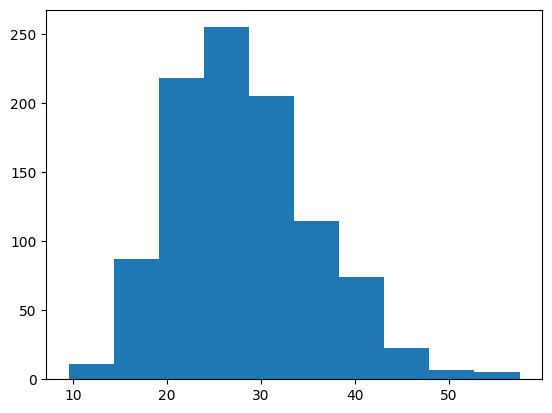

In [31]:
plt.hist(Chi_distribution)
plt.show()

First moment of the chi squared distribution is equal to the number of degrees fo freedom

In [32]:
doF = np.average(Chi_distribution) 

Latex(f"$$\\text{{Degrees of freedom (rounded):\t}} {{{round(doF)}}}    \\newline \\text{{Uncertainties:\t}} {{{round(n-doF)}}}$$")

<IPython.core.display.Latex object>

<h3>Manually finding parameters a and b with chi squared

In [33]:
def min_chi(func,min,max,a=0,b=0,prec=.001):

    r = (-1+np.sqrt(5))/2  #golden ratio

    xmin = min
    xmax = max

    while abs(xmax-xmin) > prec:

        n = xmin +     r* abs(xmax-xmin)
        m = xmin + (1-r)* abs(xmax-xmin)
        
        if a == True:
            
            if func(data,sigma,func1,m,b) > func(data,sigma,func1,n,b):
                xmin = m
            else: 
                xmax = n

        if b == True:
            
            if func(data,sigma,func1,a,m) > func(data,sigma,func1,a,n):
                xmin = m
            else: 
                xmax = n


    if a == True:
        return xmin,func(data,sigma,func1,xmin,b)
    if b == True:
        return xmin,func(data,sigma,func1,a,xmin)

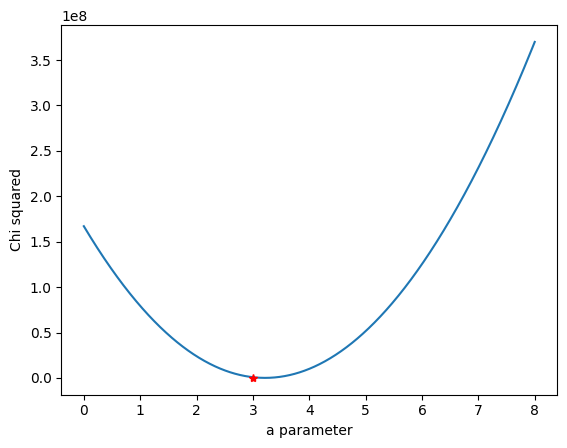

In [34]:
a_s = np.linspace(0,8,1000)
q_a = [Q_sqr(data,sigma,func1,i,b=0) for i in a_s]

min_a = min_chi(Q_sqr,0,8,a=True,b=7)

plt.plot(a_s,q_a)
plt.plot(min_a[0],min_a[1], 'r*')
plt.xlabel("a parameter")
plt.ylabel("Chi squared")
plt.show()

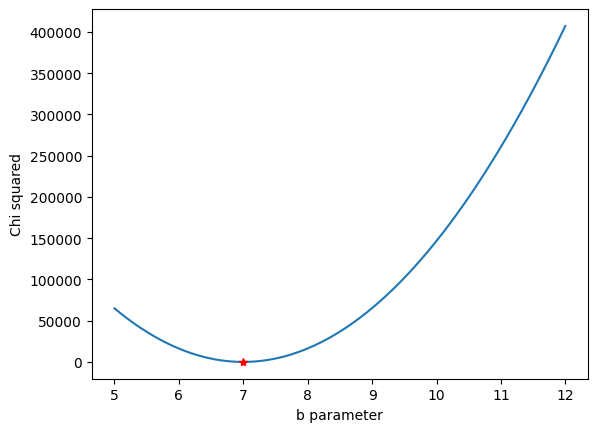

In [35]:
b_s = np.linspace(5,12,1000)
q_b = [Q_sqr(data,sigma,func1,a=3,b=i) for i in b_s]

min_b = min_chi(Q_sqr,0,8,a=3,b=True)

plt.plot(b_s,q_b)
plt.plot(min_b[0],min_b[1], 'r*')
plt.xlabel("b parameter")
plt.ylabel("Chi squared")
plt.show()


In [36]:
Latex(f"$$ a = {{{min_a[0]}}} \\newline b = {{{min_b[0]}}}$$")

<IPython.core.display.Latex object>